# Variational Autoencoder

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from time import time
from tqdm.notebook import tqdm, trange

import os

2023-03-03 16:23:03.348355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 16:23:03.517798: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-03 16:23:04.093718: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-03 16:23:04.093813: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

## GPU settings

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

2023-03-03 16:23:11.465635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2023-03-03 16:23:11.502714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 16:23:11.506033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Implementing actual model
In this chapter we try to implement the variational image compressing model of the paper on the basis of code written above.

## Encoder

In [4]:
class Encoder(tf.keras.layers.Layer):
    """Encoder network for the VAE."""
    
    def __init__(self, N, M, k, format='channel_last'):
        """Initializes the encoder."""
        
        super(Encoder, self).__init__()
        self.N      = N
        self.M      = M
        self.conv1  = tf.keras.layers.Conv2D(self.N, k, strides=2, padding='same', data_format=format)
        self.conv2  = tf.keras.layers.Conv2D(self.N, k, strides=2, data_format=format)
        self.conv3  = tf.keras.layers.Conv2D(self.N, k, strides=1, data_format=format)
        self.conv4  = tf.keras.layers.Conv2D(self.M, k, strides=1, data_format=format)
        self.gdn1   = tfc.layers.GDN()
        self.gdn2   = tfc.layers.GDN()
        self.gdn3   = tfc.layers.GDN()
    
    def call(self, inputs):
        """Forward pass of the encoder."""
        x = self.conv1(inputs)
        x = self.gdn1(x)
        x = self.conv2(x)
        x = self.gdn2(x)
        x = self.conv3(x)
        x = self.gdn3(x)
        z = self.conv4(x)
        del x
        return z

## Hyperprior

In [5]:
class H_a(tf.keras.layers.Layer):
    """Encoder network for the Hyperprior."""
    
    def __init__(self, N, k1, k2, format):
        """Initializes the encoder."""
        
        super(H_a, self).__init__()
        self.N      = N

        self.conv1  = tf.keras.layers.Conv2D(self.N, k1, strides=1, activation='relu', data_format=format)
        self.conv2  = tf.keras.layers.Conv2D(self.N, k2, strides=1, activation='relu', data_format=format)
        self.conv3  = tf.keras.layers.Conv2D(self.N, k2, strides=2, data_format=format)

    def call(self, inputs):
        """Forward pass of the encoder."""
        x = tf.abs(inputs)
        x = self.conv1(x)
        x = self.conv2(x)
        z = self.conv3(x)
        return z


class H_s(tf.keras.layers.Layer):
    """Decocer network for the Hyperprior."""
    
    def __init__(self, N, M, k1, k2, format):
        """Initializes the decoder."""
        
        super(H_s, self).__init__()
        self.N      = N
        self.M      = M
        
        self.conv1  = tf.keras.layers.Conv2DTranspose(self.N, k2, strides=2, activation='relu', data_format=format)
        self.conv2  = tf.keras.layers.Conv2DTranspose(self.N, k2, strides=1, activation='relu', data_format=format)
        self.conv3  = tf.keras.layers.Conv2DTranspose(self.M, k1, strides=1, activation='relu', data_format=format)

    def call(self, inputs):
        """Forward pass of the decoder."""
        x = self.conv1(inputs)
        x = self.conv2(x)
        z = self.conv3(x)
        return z

## Entropy model

In [6]:
def indexes(i):
    return i

def get_indexed_emodel(num_scales):
    return tfc.LocationScaleIndexedEntropyModel(
        prior_fn=tfc.NoisyNormal,
        num_scales=num_scales,
        scale_fn = indexes,
        coding_rank=1,
     )

def get_batched_emodel(batch_shape=()):
    return tfc.ContinuousBatchedEntropyModel(
        prior=tfc.distributions.NoisyDeepFactorized(batch_shape=batch_shape),
        coding_rank=1
    )


## Decoder

In [7]:
class Decoder(tf.keras.layers.Layer):
    """Encoder network for the VAE."""
    
    def __init__(self, N, k, c, format):
        """Initializes the encoder."""
        
        super(Decoder, self).__init__()
        self.N      = N
        self.conv2  = tf.keras.layers.Conv2DTranspose(self.N, k, strides=1, data_format=format)
        self.conv1  = tf.keras.layers.Conv2DTranspose(self.N, k, strides=1, data_format=format)
        self.conv3  = tf.keras.layers.Conv2DTranspose(self.N, k, strides=2, data_format=format, output_padding=(1, 1))
        self.conv4  = tf.keras.layers.Conv2DTranspose(c, k, strides=2, data_format=format, padding='same')
        self.gdn1   = tfc.layers.GDN(inverse=True)
        self.gdn2   = tfc.layers.GDN(inverse=True)
        self.gdn3   = tfc.layers.GDN(inverse=True)
    
    def call(self, inputs):
        """Forward pass of the decoder."""
        x = self.conv1(inputs)
        x = self.gdn1(x)
        x = self.conv2(x)
        x = self.gdn2(x)
        x = self.conv3(x)
        x = self.gdn3(x)
        z = self.conv4(x)
        return z

## Full model

In [8]:
class Balle(tf.keras.Model):
    """Encoder network for the VAE."""
    
    def __init__(self, N, M, k1, k2, c, format):
        """Initializes the encoder."""
        
        super(Balle, self).__init__()

        self.iemodel = get_indexed_emodel(19)
        self.bemodel = get_batched_emodel(())
        self.encoder = Encoder(N, M, k2, format)
        self.decoder = Decoder(N, k2, c, format)
        self.H_a     = H_a(N, k1, k2, format)
        self.H_s     = H_s(N, M, k1, k2, format)


    def call(self, inputs, training = True):

        y = self.encoder(inputs)
        z = self.H_a(y)
        z_tilde, rate_b = self.bemodel(z, training=training)
        sigma = self.H_s(z_tilde)

        y_tilde, rate_i = self.iemodel(y, sigma, training=training)

        x_tilde = self.decoder(y_tilde)

        return x_tilde, rate_i, rate_b
    

class Balle_ff(tf.keras.Model):
    """Encoder network for the VAE."""
    
    def __init__(self, N, M, k1, k2, c, format):
        """Initializes the encoder."""
        
        super(Balle_ff, self).__init__()

        #self.iemodel = get_indexed_emodel(5)
        self.bemodel = get_batched_emodel((19, 19))
        self.encoder = Encoder(N, M, k2, format)
        self.decoder = Decoder(N, k2, c, format)
        self.H_a     = H_a(N, k1, k2, format)
        self.H_s     = H_s(N, M, k1, k2, format)


    def call(self, inputs, training = True):

        y = self.encoder(inputs)

        y_tilde, rate_i = self.bemodel(y, training=training)

        x_tilde = self.decoder(y_tilde)

        return x_tilde, rate_i

# Functions

In [9]:
def read_data_numpy(data_path, format='channels_last'):
    """Read data from file and return a numpy array."""
    with open(data_path, 'rb') as f:
        # read data from file
        X = np.fromfile(f, dtype=np.uint8)
        # reshape data to (num_images, 3, 96, 96)
        X = np.reshape(X, (-1, 3, 96, 96))
        # transpose data to (num_images, 96, 96, 3) to match the image format
        # NOTE that tensorflow may use a different image format (e.g., channels_first: (num_images, 3, 96, 96))
        if format=='channels_last':
            return np.transpose(X, (0, 3, 2, 1))
        elif format=='channels_first':
            return np.transpose(X, (0, 1, 3, 2))
        else:
            print('unrecognized option "'+format+'"')
            return None
    

def visualize_images(images, format):
    """Visualize images in a grid of 4 rows x 4 columns."""
    # Create a list of 16 images by random sampling from the dataset first dimension without replacement
    image_list = [images[i] for i in np.random.choice(images.shape[0], 16, replace=False)]
    if format=='channels_first':
        image_list = [np.transpose(image, (1, 2, 0)) for image in image_list]
    
    # check if the images are normalized
    norm = np.max(image_list) <= 1.0

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if norm:
            ax.imshow(image_list[i]) # no need to convert to uint8
        else:
            ax.imshow(image_list[i].astype(np.uint8)) # convert to uint8 for visualization
        ax.axis('off')

    # Show the plot
    plt.show()

# Constants

In [10]:
DATA_FOLDER = "../data/stl10/stl10_binary/"
DATA_FILE   = "unlabeled_X.bin"

TRAINING_SET_SIZE      = 8_000 # 80,000 images for training -> 20,000 images for validation
VALIDATION_SET_SIZE    = 2_000
BATCH_SIZE_PER_REPLICA = 64 # batch size per gpu replica (e.g., 64 for 1 gpu, 128 for 2 gpus, etc.)
EPOCHS                 = 50


# Code for training

### Load data

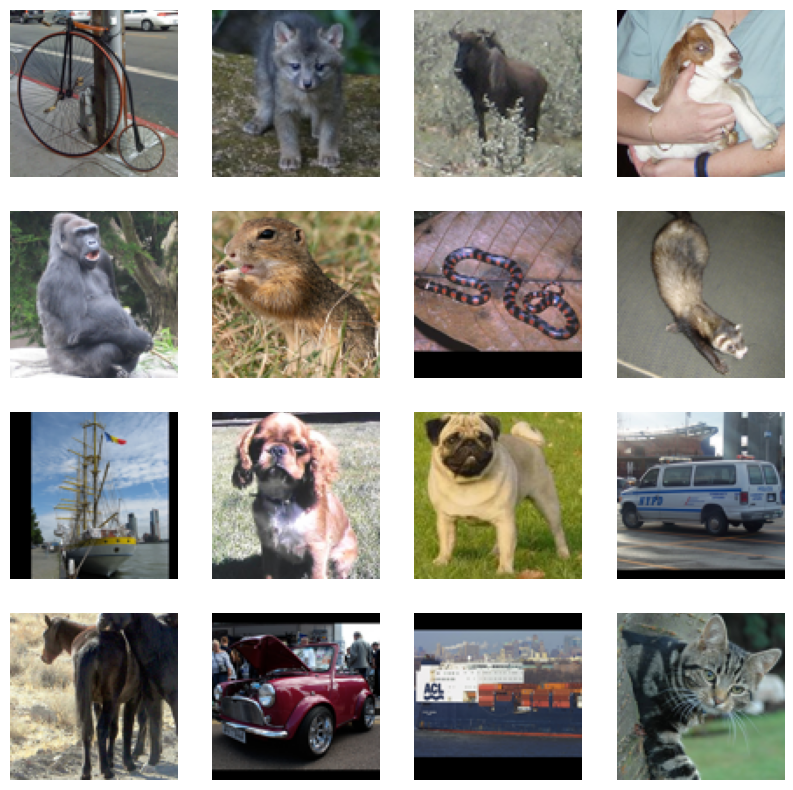

(100000, 3, 96, 96)


In [11]:
data_path = os.path.join(DATA_FOLDER, DATA_FILE)
ch_format = 'channels_first'

data = read_data_numpy(data_path, ch_format)
data = data.astype('float32') / 255.0

visualize_images(data, ch_format)
print(data.shape)

### Split train and test data

In [12]:
train_images = data[:TRAINING_SET_SIZE]
test_images  = data[TRAINING_SET_SIZE:TRAINING_SET_SIZE+VALIDATION_SET_SIZE]

buffer_size       = len(train_images) # buffer size for shuffling
global_batch_size = BATCH_SIZE_PER_REPLICA #* strategy.num_replicas_in_sync # global batch size (in our case 2gpu * BATCH_SIZE_PER_REPLICA)

# create train and test datasets using tf.data API

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(global_batch_size)
test_dataset  = tf.data.Dataset.from_tensor_slices(test_images).batch(global_batch_size)

2023-03-03 16:23:40.403796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 16:23:40.405929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 16:23:40.409319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 16:23:40.412234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there

### Create model

In [13]:
# create a VAE model using the strategy scope to distribute the model on multiple gpus
vae       = Balle(N=128, M=192, k1=3, k2=3, c=3, format=ch_format)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) 

### Training

In [14]:

@tf.function # compile the function to a graph for faster execution
def train_step(inputs, vae):
    """Train step function."""
    print('Inside train step')
    with tf.GradientTape() as tape: # create a tape to record operations
        
        reconstructed, ratei, rateb = vae(inputs) # forward pass
        print('calculated reconstructed')
        loss = tf.reduce_mean(tf.square(inputs - reconstructed)) + 0.5*(tf.reduce_mean(ratei)+tf.reduce_mean(rateb))
        print('computed loss')
        
    gradients = tape.gradient(loss, vae.trainable_variables) # compute gradients    
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables)) # gradient descent
    print('applied gradients')
    return loss # return loss for logging


In [15]:
for epoch in range(EPOCHS):
    total_loss = 0.0 
    num_batches = 0 
    for inputs in tqdm(train_dataset, 'training steps'): 
        loss = train_step(inputs, vae) # distributed training
        print('finished training step')
        total_loss += loss
        num_batches += 1 # count number of batches
    train_loss = total_loss / num_batches # compute average loss
    print('Epoch {} train loss: {}'.format(epoch, train_loss))

    total_loss = 0.0
    num_batches = 0
    for inputs in tqdm(test_dataset, 'validation steps'): 
        reconstructed = vae(inputs, training=False) # forward pass
        loss = tf.reduce_mean(tf.square(inputs - reconstructed)) # MSE loss
        total_loss += loss # sum losses across replicas
        num_batches += 1 # count number of batches
    test_loss = total_loss / num_batches # compute average loss
    print('Epoch {} test loss: {}'.format(epoch, test_loss))

training steps:   0%|          | 0/125 [00:00<?, ?it/s]

Inside train step
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
calculated reconstructed
computed loss
applied gradients
Inside train step
calculated reconstructed
computed loss
applied gradients


: 

: 